# Reference

https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html

https://github.com/yfeng997/MadMario

In [1]:
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, time, datetime, os
import matplotlib.pyplot as plt

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros

from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage
from gym_super_mario_bros.actions import RIGHT_ONLY, SIMPLE_MOVEMENT, COMPLEX_MOVEMENT

c:\Users\zly20\AppData\Local\Programs\Python\Python38\lib\site-packages\torchrl\data\replay_buffers\samplers.py:37: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. If you installed TorchRL from PyPI, please report the bug on TorchRL github. If you installed TorchRL locally and/or in development mode, check that you have all the required compiling packages.
  warnings.warn(EXTENSION_WARNING)


In [2]:
# Initialize Super Mario environment (in v0.26 change render mode to 'human' to see results on the screen)
if gym.__version__ < '0.26':
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", new_step_api=True)
else:
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='rgb_array', apply_api_compatibility=True)

# Limit the action-space to
#   0. walk right
#   1. jump right
env = JoypadSpace(env, SIMPLE_MOVEMENT)

env.reset()
next_state, reward, done, trunc, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

c:\Users\zly20\AppData\Local\Programs\Python\Python38\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
c:\Users\zly20\AppData\Local\Programs\Python\Python38\lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


c:\Users\zly20\AppData\Local\Programs\Python\Python38\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [3]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape, antialias=True), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=2)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=128)
if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=4, new_step_api=True)
else:
    env = FrameStack(env, num_stack=4)

In [4]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Mario's DNN to predict the most optimal action - we implement this in the Learn section
        self.net = MarioNet(self.state_dim, self.action_dim).float()
        self.net = self.net.to(device=self.device)

        self.exploration_rate = 0.5
        self.exploration_rate_decay = 0.9999999
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = 5e5  # no. of experiences between saving Mario Net

    def act(self, state):
        """
    Given a state, choose an epsilon-greedy action and update value of step.

    Inputs:
    state(``LazyFrame``): A single observation of the current state, dimension is (state_dim)
    Outputs:
    ``action_idx`` (``int``): An integer representing which action Mario will perform
    """
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        else:
            state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
            state = torch.tensor(state, device=self.device).unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx

In [5]:
class Mario(Mario):  # subclassing for continuity
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.memory = TensorDictReplayBuffer(storage=LazyMemmapStorage(70000, device=torch.device("cpu")))
        self.batch_size = 512

    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience to self.memory (replay buffer)

        Inputs:
        state (``LazyFrame``),
        next_state (``LazyFrame``),
        action (``int``),
        reward (``float``),
        done(``bool``))
        """
        def first_if_tuple(x):
            return x[0] if isinstance(x, tuple) else x
        state = first_if_tuple(state).__array__()
        next_state = first_if_tuple(next_state).__array__()

        state = torch.tensor(state)
        next_state = torch.tensor(next_state)
        action = torch.tensor([action])
        reward = torch.tensor([reward])
        done = torch.tensor([done])

        # self.memory.append((state, next_state, action, reward, done,))
        self.memory.add(TensorDict({"state": state, "next_state": next_state, "action": action, "reward": reward, "done": done}, batch_size=[]))

    def recall(self):
        """
        Retrieve a batch of experiences from memory
        """
        batch = self.memory.sample(self.batch_size).to(self.device)
        state, next_state, action, reward, done = (batch.get(key) for key in ("state", "next_state", "action", "reward", "done"))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

In [6]:
class MarioNet(nn.Module):
    """mini CNN structure
  input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
  """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 128:
            raise ValueError(f"Expecting input height: 128, got: {h}")
        if w != 128:
            raise ValueError(f"Expecting input width: 128, got: {w}")

        self.online = self.__build_cnn(c, output_dim)

        self.target = self.__build_cnn(c, output_dim)
        self.target.load_state_dict(self.online.state_dict())

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

    def __build_cnn(self, c, output_dim):
        test_input = torch.zeros(1, c, 128, 128)
        conv_net = nn.Sequential(
            nn.Conv2d(c, 32, 8, 4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1),
            nn.ReLU()
        )
        with torch.no_grad():
            conv_out = conv_net(test_input)
        conv_out_size = conv_out.view(1, -1).size(1)

        return nn.Sequential(
            *conv_net,
            nn.Flatten(),
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

In [7]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.gamma = 0.95

    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

In [8]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.0001)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

In [9]:
class Mario(Mario):
    def save(self):
        save_path = (
            self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")

In [10]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.burnin = 1e4  # min. experiences before training
        self.learn_every = 8  # no. of experiences between updates to Q_online
        self.sync_every = 5e3  # no. of experiences between Q_target & Q_online sync

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate
        td_est = self.td_estimate(state, action)

        # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

In [11]:
class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_lengths", "ep_avg_losses", "ep_avg_qs", "ep_rewards"]:
            plt.clf()
            plt.plot(getattr(self, f"moving_avg_{metric}"), label=f"moving_avg_{metric}")
            plt.legend()
            plt.savefig(getattr(self, f"{metric}_plot"))

Using CUDA: True

Episode 0 - Step 69 - Epsilon 0.4999965500117319 - Mean Reward 251.0 - Mean Length 69.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 0.344 - Time 2025-03-24T23:36:13
Episode 10 - Step 7201 - Epsilon 0.49964007958709217 - Mean Reward 744.364 - Mean Length 654.636 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 21.859 - Time 2025-03-24T23:36:35
Episode 20 - Step 15094 - Epsilon 0.49924586924835185 - Mean Reward 705.286 - Mean Length 718.762 - Mean Loss 0.174 - Mean Q Value 0.161 - Time Delta 51.503 - Time 2025-03-24T23:37:26
Episode 30 - Step 20704 - Epsilon 0.49896587084874605 - Mean Reward 675.161 - Mean Length 667.871 - Mean Loss 0.242 - Mean Q Value 0.833 - Time Delta 46.758 - Time 2025-03-24T23:38:13
Episode 40 - Step 28488 - Epsilon 0.49857762691981017 - Mean Reward 713.585 - Mean Length 694.829 - Mean Loss 0.273 - Mean Q Value 1.503 - Time Delta 67.002 - Time 2025-03-24T23:39:20
Episode 50 - Step 34838 - Epsilon 0.4982611306092718 - Mean Reward 699.627 - Mean 

KeyboardInterrupt: 

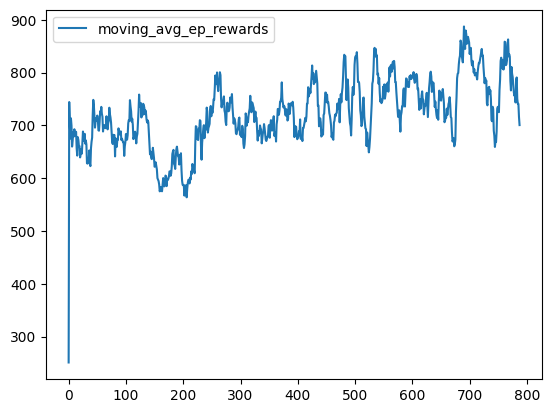

In [12]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Mario(state_dim=(4, 128, 128), action_dim=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)

episodes = 30000
for e in range(episodes):

    frames = []
    state = env.reset()

    # Play the game!
    while True:

        # Run agent on the state
        action = mario.act(state)

        # Agent performs action
        next_state, reward, done, trunc, info = env.step(action)

        # Remember
        mario.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = mario.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if (e % 10 == 0) or (e == episodes - 1):
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)

    if (e % 500 == 0):
        torch.save(mario.net.state_dict(), f"mario_intermediate_{e}.pth")
        
# Save the final model at the end
torch.save(mario.net.state_dict(), "mario_final.pth")
print("Final model saved as mario_final.pth")
    

In [ ]:
import gc
# Clear memory
gc.collect()
torch.cuda.empty_cache()

# Initialize environment with real-time display
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='human', apply_api_compatibility=True)
env = JoypadSpace(env, SIMPLE_MOVEMENT)

# Load trained Mario model
mario = Mario(state_dim=(4, 128, 128), action_dim=len(SIMPLE_MOVEMENT), save_dir=None)  # No need for save_dir
mario.net.load_state_dict(torch.load("mario_intermediate_9250.pth", map_location="cpu"))
mario.net.eval()

# Reset environment
state, _ = env.reset()
done = False
stuck_frames = 0
MAX_STUCK_FRAMES = 100  # Adjust as needed

while not done:
    state_np = state.__array__()

    with torch.no_grad():
        action = mario.act(state_np)

    next_state, reward, done, trunc, _ = env.step(action)
    done = done or trunc  # ✅ Handle truncation properly

    # Detect if stuck: If reward is 0 and action is repeated
    if reward == 0:
        stuck_frames += 1
    else:
        stuck_frames = 0  # Reset if Mario makes progress

    # Stop recording if Mario is stuck for too long
    if stuck_frames > MAX_STUCK_FRAMES:
        print("⚠️ Mario is stuck! Resetting environment to avoid error.")
        state, _ = env.reset()
        stuck_frames = 0  # Reset counter
        continue

    state = next_state

    frame = env.render()
    if isinstance(frame, np.ndarray):
        print(f"Frame details before processing: shape={frame.shape}, dtype={frame.dtype}, strides={frame.strides}")  # Debug info

        frame = np.ascontiguousarray(frame).astype(np.uint8)  # ✅ Ensure proper memory layout

        if frame.shape[-1] == 4:  # ✅ Convert RGBA to RGB
            frame = frame[..., :3]

        print(f"Frame after fixing: shape={frame.shape}, dtype={frame.dtype}, strides={frame.strides}")  # Debug info

    time.sleep(0.01)

env.close()

C:\Users\zly20\AppData\Local\Temp\ipykernel_4140\2971229949.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mario.net.load_state_dict(torch.load("mario_intermediate_925

ValueError: At least one stride in the given numpy array is negative, and tensors with negative strides are not currently supported. (You can probably work around this by making a copy of your array  with array.copy().) 

: 